# 1) Prepare Machine
- Mount google drive
- Clone ssd-keras repository
- Download and prepare VOC07 and VOC12 datasets

In [0]:
#Some Settings for Preparing emilia-colab!
set_mount_drive = True
set_clone_repo = True
set_prepare_voc = False #Only use if you don't have the VOC7+12 HDF5s in your gdrive
set_install_tfgpu = True

In [0]:
if set_mount_drive:
  
  from google.colab import drive
  drive.mount('/content/gdrive')

In [0]:
%%capture
if set_clone_repo:

  !git clone https://github.com/henritomas/ssd-keras.git

In [0]:

if set_install_tfgpu:
  
  !pip install tensorflow-gpu==1.15.*
  !pip install larq

In [0]:
import os
import pathlib

def folder_not_here(FOLDER_PATH):
  if FOLDER_PATH in pathlib.Path.cwd().parts:
    while FOLDER_PATH in pathlib.Path.cwd().parts:
      return False
  elif not pathlib.Path(FOLDER_PATH).exists():
      return True

In [0]:
%cd /content/
#PJREDDIE's mirror sometimes the server is randomly slow to download, Oxford's server more consistent
# http://host.robots.ox.ac.uk/pascal/VOC/

if set_prepare_voc:

  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

/content


In [0]:
%%capture
if set_prepare_voc:

  VOC_IMAGES_DIR = '/content/voc7+12_images'

  !tar -xvf "/content/VOCtrainval_06-Nov-2007.tar"
  !tar -xvf "/content/VOCtest_06-Nov-2007.tar"
  !tar -xvf "/content/VOCtrainval_11-May-2012.tar"

  !mkdir $VOC_IMAGES_DIR
  !mv -v /content/VOCdevkit/VOC2007/JPEGImages/* $VOC_IMAGES_DIR
  !mv -v /content/VOCdevkit/VOC2012/JPEGImages/* $VOC_IMAGES_DIR

  #!mv /content/ssd-keras/dataset_voc_csv/2007_2012_person_trainval.csv $VOC_IMAGES_DIR
  #!mv /content/ssd-keras/dataset_voc_csv/2007_person_test.csv $VOC_IMAGES_DIR

# 2) Start of actual Jupyter Notebook

In [0]:
%cd /content/ssd-keras/

/content/ssd-keras


In [0]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

#from models.tfkeras_ssd_mobilenet_beta import ssd_300
#from models.tfkeras_ssd_mobilenet_official import ssd_300
from models.tfkeras_ssd_mobilenet_3x3 import ssd_300

from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.tensorflow_keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.tensorflow_keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.tensorflow_object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [0]:
img_height = 300  # Height of the input images
img_width = 300  # Width of the input images
img_channels = 3  # Number of color channels of the input images
subtract_mean = [123, 117, 104]  # The per-channel mean of the images in the dataset
swap_channels = True  # The color channel order in the original SSD is BGR
n_classes = 20  # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_voc = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]  # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]  # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_voc
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]]  # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True

# THESE ARE VGG16 ANCHOR BOX SETTINGS. IF YOU APPLY THIS TO ANY OTHER BACKBONE (e.g. MOBILENET) mAP DROPS HARD AND 
# TFLITE MODEL HAS INCORRECT ANCHOR BOX OFFSETS ADDED. BE SURE TO SET TO 'None' FOR OTHER BACKBONES
#steps = [8, 16, 32, 64, 100, 300]  # The space between two adjacent anchor box center points for each predictor layer.
#offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]  # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.

# USE THESE BY DEFAULT
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended

clip_boxes = False  # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2]  # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids'  # Whether the box coordinates to be used as targets for the model should be in the 'centroids', 'corners', or 'minmax' format, see documentation
normalize_coords = True

In [0]:
import os
GDRIVE = '/content/gdrive/My Drive/emilia-colab/ssd-keras/'
VOC_HDF5_TRAIN = os.path.join(GDRIVE, 'dataset_hdf5/full_pascal_voc_07+12_trainval.h5')
VOC_HDF5_TEST = os.path.join(GDRIVE, 'dataset_hdf5/full_pascal_voc_07_test.h5')

#SAVED_MODEL = os.path.join(GDRIVE, 'ssd_mb_full_voc/ssd_vgg_epoch-02_loss-8.67_val_loss-7.86.h5')

In [0]:
#DOWNLOAD IN CASE YOU WANT TO USE "beta version" WHERE MOBILENET IS BUILT INSTEAD OF USING KERAS.APPLICATIONS
!wget https://github.com/sudhakar-sah/Face-detection-with-mobilenet-ssd/raw/master/base_models/mobilenet_1_0_224_tf.h5

In [0]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(mode = 'training',
              image_size=(img_height, img_width, img_channels),
              n_classes=n_classes,
              l2_regularization=0.0005,
              #l2_regularization=0.0,
              scales=scales,
              aspect_ratios_per_layer=aspect_ratios,
              two_boxes_for_ar1=two_boxes_for_ar1,
              steps=steps,
              offsets=offsets,
              clip_boxes=clip_boxes,
              variances=variances,
              coords=coords,
              normalize_coords=normalize_coords,
              subtract_mean=subtract_mean,
              divide_by_stddev=None,
              swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.

#model.load_weights('./mobilenet_1_0_224_tf.h5', by_name=True)
#model.load_weights('/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_vgg_epoch-05_loss-3.67_val_loss-3.48.h5', by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

#opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)
opt = Adam(lr=5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)
#opt = SGD(lr=1e-2, momentum=0.9, decay=0.0, nesterov=False)

#pytorch-ssd in https://github.com/qfgaohao/pytorch-ssd/blob/master/train_ssd.py 
#uses 1e-2 SGD for training MobileNetv2

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=opt, loss=ssd_loss.compute_loss)

conv11 shape:  (?, 18, 18, 512)
conv13 shape:  (?, 9, 9, 1024)
conv14 shape (?, 5, 5, 512)
conv15 shape (?, 3, 3, 256)
conv16 shape (?, 2, 2, 256)
conv17 shape (?, 1, 1, 128)


In [0]:
#1.2 Load model h5 to preserve optimizer state for training

# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_vgg_epoch-10_loss-3.02_val_loss-3.05.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               #'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


In [0]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=VOC_HDF5_TRAIN)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=VOC_HDF5_TEST)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading evaluation-neutrality annotations: 100%|██████████| 4952/4952 [00:00<00:00, 7083.61it/s]
Number of images in the training dataset:	 16551
Number of images in the validation dataset:	  4952


In [0]:
# 3: Set the batch size.

batch_size = 32

# 4: Define the image processing chain.

ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=subtract_mean)

mobilenet_data_augmentation = DataAugmentationVariableInputSize(resize_height=img_height,
                                                                resize_width=img_width,
                                                                random_brightness=(-48, 48, 0.5),
                                                                random_contrast=(0.5, 1.8, 0.5),
                                                                random_saturation=(0.5, 1.8, 0.5),
                                                                random_hue=(18, 0.5),
                                                                random_flip=0.5,
                                                                min_scale=0.3,
                                                                max_scale=1.0,
                                                                min_aspect_ratio = 0.5,
                                                                max_aspect_ratio = 2.0,
                                                                n_trials_max=3,
                                                                clip_boxes=True,
                                                                overlap_criterion='area',
                                                                bounds_box_filter=(0.4, 1.0),
                                                                bounds_validator=(0.5, 1.0),
                                                                n_boxes_min=1,
                                                                background=subtract_mean)
    
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv11_mbox_conf').output_shape[1:3],
                 model.get_layer('conv13_mbox_conf').output_shape[1:3],
                 model.get_layer('conv14_2_mbox_conf').output_shape[1:3],
                 model.get_layer('conv15_2_mbox_conf').output_shape[1:3],
                 model.get_layer('conv16_2_mbox_conf').output_shape[1:3],
                 model.get_layer('conv17_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    #neg_iou_limit=0.5,
                                    neg_iou_limit=0.2,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[mobilenet_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

In [0]:
#!rm -v /content/gdrive/My\ Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/*

removed '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_mb_full_voc.tflite'
removed '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_vgg_epoch-01_loss-7.23_val_loss-5.51.h5'
removed '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_vgg_epoch-02_loss-5.11_val_loss-4.58.h5'
removed '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_vgg_epoch-03_loss-4.40_val_loss-4.03.h5'
removed '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_vgg_epoch-04_loss-3.99_val_loss-3.70.h5'
removed '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_vgg_epoch-05_loss-3.67_val_loss-3.48.h5'
removed '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_vgg_training_log.csv'


In [0]:
#%mkdir '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd7_voc_person'
WEIGHTS_DIR = os.path.join(GDRIVE, 'ssd_mb_full_voc/ssd_mb_epoch-{epoch:02d}_loss-{loss:.2f}_val_loss-{val_loss:.2f}.h5')
LOG_DIR = os.path.join(GDRIVE, 'ssd_mb_full_voc/ssd_mb_training_log.csv')

In [0]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 11:
        return 0.001
    elif epoch < 16:
        return 0.0001
    else:
        return 0.00001

import math
def cosine_annealing_lr(epoch):

  #hyperparams used by pytorch-ssd
  t_max = 200
  eta_max = 1e-2
  eta_min = 0

  lr = eta_min + (eta_max - eta_min) * (1 + math.cos(math.pi * epoch / t_max)) / 2

  return lr

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                #schedule=cosine_annealing_lr,
                                                verbose=1)

In [0]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath=WEIGHTS_DIR,
                                   monitor='val_loss',
                                   verbose=1,
                                   #save_best_only=True,
                                   save_best_only=False, #saves every epoch regardless of val_loss
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename=LOG_DIR,
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=5,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=1e-5)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             #learning_rate_scheduler,
             terminate_on_nan]

In [0]:
# TODO: Set the epochs to train for.
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 10
final_epoch     = 20
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 11/20
 155/1000 [===>..........................] - ETA: 8:01 - loss: 3.0271
Epoch 00011: saving model to /content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_vgg_epoch-11_loss-2.93_val_loss-3.03.h5
1000/1000 [==============================] - 1155s 1s/step - loss: 2.9305 - val_loss: 3.0271
Epoch 12/20
 155/1000 [===>..........................] - ETA: 7:52 - loss: 2.9834
Epoch 00012: saving model to /content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_vgg_epoch-12_loss-2.87_val_loss-2.98.h5
1000/1000 [==============================] - 1080s 1s/step - loss: 2.8753 - val_loss: 2.9834
Epoch 13/20
 155/1000 [===>..........................] - ETA: 7:55 - loss: 2.9591
Epoch 00013: saving model to /content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_vgg_epoch-13_loss-2.83_val_loss-2.96.h5
1000/1000 [==============================] - 1077s 1s/step - loss: 2.8307 - val_loss: 2.9591
Epoch 14/20
 155/1000 [===>..........................] - ETA: 7:

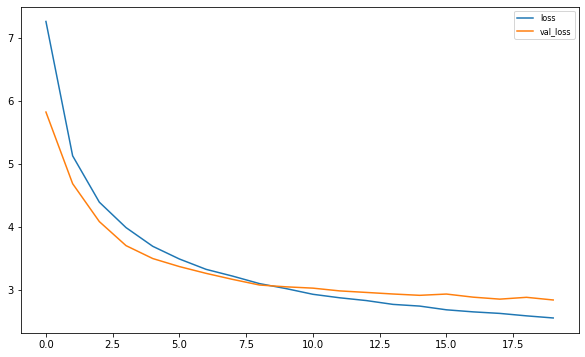

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

record_df = pd.read_csv(LOG_DIR)
#print(record_df['loss'])

plt.figure(figsize=(10,6))
plt.plot(record_df['loss'], label='loss')
plt.plot(record_df['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 8});

In [0]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [0]:
# 2: Generate samples

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

try:
    print("Image:", batch_filenames[i])
except:
    print("Using hdf5 cache: No image filepath")
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

# 3: Make a prediction

y_pred = model.predict(batch_images)

# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Using hdf5 cache: No image filepath

Ground truth boxes:

[[  1  11  70 494 238]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.   1.   4.  98. 498. 239.]]


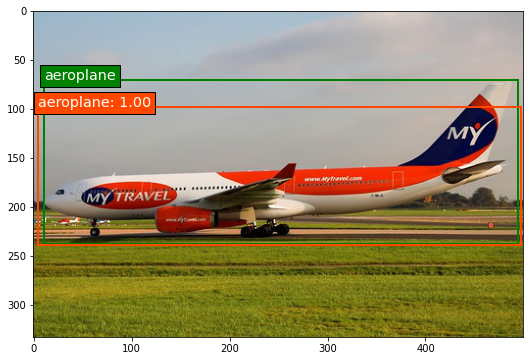

In [0]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(10,6))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

## Evaluate Model on VOC 2007

In [0]:
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=VOC_HDF5_TEST)

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

Loading evaluation-neutrality annotations: 100%|██████████| 4952/4952 [00:00<00:00, 7459.76it/s]


In [0]:
model_mode = 'training'

evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    #batch_size=4,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 4952

Producing predictions batch-wise: 100%|██████████| 619/619 [01:19<00:00,  7.79it/s]
Matching predictions to ground truth, class 1/20.: 100%|██████████| 4028/4028 [00:00<00:00, 16933.18it/s]
Matching predictions to ground truth, class 2/20.: 100%|██████████| 6692/6692 [00:00<00:00, 25833.12it/s]
Matching predictions to ground truth, class 3/20.: 100%|██████████| 21562/21562 [00:00<00:00, 26408.18it/s]
Matching predictions to ground truth, class 4/20.: 100%|██████████| 11227/11227 [00:00<00:00, 22245.84it/s]
Matching predictions to ground truth, class 5/20.: 100%|██████████| 21882/21882 [00:00<00:00, 33288.32it/s]
Matching predictions to ground truth, class 6/20.: 100%|██████████| 5565/5565 [00:00<00:00, 28387.77it/s]
Matching predictions to ground truth, class 7/20.: 100%|██████████| 29131/29131 [00:01<00:00, 18258.45it/s]
Matching predictions to ground truth, class 8/20.: 100%|██████████| 3853/3853 [00:00<00:00, 19880.81it/s]
Matching p

In [0]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

aeroplane     AP    0.655
bicycle       AP    0.681
bird          AP    0.618
boat          AP    0.569
bottle        AP    0.293
bus           AP    0.737
car           AP    0.721
cat           AP    0.788
chair         AP    0.382
cow           AP    0.615
diningtable   AP    0.642
dog           AP    0.746
horse         AP    0.77
motorbike     AP    0.657
person        AP    0.604
pottedplant   AP    0.343
sheep         AP    0.581
sofa          AP    0.664
train         AP    0.756
tvmonitor     AP    0.651

              mAP   0.624


##  Convert Model to tf lite

In [0]:
%cd /content/ssd-keras/
!git pull

/content/ssd-keras
Already up to date.


In [0]:
%cd /content/ssd-keras/

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

#from models.tfkeras_ssd_mobilenet_beta import ssd_300
#from models.tfkeras_ssd_mobilenet_official import ssd_300
from models.tfkeras_ssd_mobilenet_3x3 import ssd_300

from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.tensorflow_keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.tensorflow_keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

/content/ssd-keras


Using TensorFlow backend.


In [0]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = '/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_mb_epoch-20_loss-2.55_val_loss-2.84.h5'
tflite_path = "/content/gdrive/My Drive/emilia-colab/ssd-keras/ssd_mb_full_voc/ssd_mb_full_voc.tflite"

In [0]:
import tensorflow

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

custom_objects={'AnchorBoxes': AnchorBoxes,
                'compute_loss': ssd_loss.compute_loss}

converter = tensorflow.lite.TFLiteConverter.from_keras_model_file(model_path,
                                                          custom_objects=custom_objects)
converter.target_spec.supported_ops = [tensorflow.lite.OpsSet.TFLITE_BUILTINS,
                                       tensorflow.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open(tflite_path, "wb").write(tflite_model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 199 variables.
INFO:tensorflow:Converted 199 variables to const ops

34665364

## Compare model outputs (Accuracy to what decimal)

In [0]:
import tensorflow as tf
import numpy as np
import time

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

#Inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

#get outputs
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [0]:
#You need to reload the model in a new session probably
tf_results = model.predict(input_data)

In [0]:
for tf_result, tflite_result in zip(tf_results, tflite_results):
    decimal = 4 # At 5 decimals, 1.34% mismatched elements with 0.02 relative difference
    error = np.testing.assert_almost_equal(tf_result, tflite_result, decimal=decimal)
    
    #IF no assertion error raised...
    if error==None:
        print("TF and TFLITE models are equal up to {} decimal places".format(decimal))

TF and TFLITE models are equal up to 4 decimal places


## TFLite inference on single image

In [0]:
#Prepare image / data

import numpy as np
from imageio import imread
from tensorflow.keras.preprocessing import image

orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

img_height=300
img_width=300

# We'll only load one image in this example.
img_path = '/content/fnsb2020.png'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

In [0]:
import tensorflow as tf
import numpy as np
import time

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

#Inference
interpreter.set_tensor(input_details[0]['index'], input_images)
interpreter.invoke()

#0=cls, 1=reg, 2=base_layers
y_pred = interpreter.get_tensor(output_details[0]['index'])

In [0]:
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=True,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded)

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[array([[ 15.  ,   1.  , 184.05,  28.24, 245.49, 297.57],
       [ 15.  ,   0.99, 131.09, 114.05, 169.52, 294.66],
       [ 15.  ,   0.99,  65.11,  97.61, 114.64, 293.94],
       [ 15.  ,   0.96,  20.18,  66.88,  86.78, 302.14],
       [ 15.  ,   0.57, 167.33,  86.99, 200.01, 248.45]])]


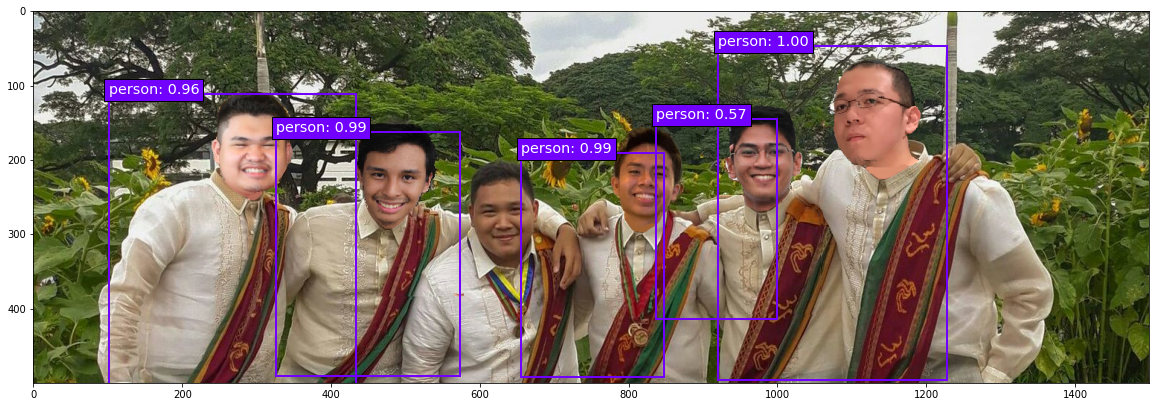

In [0]:
from matplotlib import pyplot as plt

# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_decoded[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})